# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
data0 = pd.read_csv('/datasets/geo_data_0.csv')
data1 = pd.read_csv('/datasets/geo_data_1.csv')
data2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
#запишем ключевые значения в переменные
BUDGET = 10e9
PRICE = 450000
OIL_WELL = 200

In [4]:
#смотрим общую информацию о таблицах
display(data0.info())
display(data1.info())
display(data2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [5]:
#смотрим первые 5 строк таблиц
display(data0.head())
display(data1.head())
display(data2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
#смотрим числовую информацию таблиц
display(data0.describe())
display(data1.describe())
display(data2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [7]:
#проверим есть ли в данных полные дубликаты по регионам
data0[data0.duplicated()]

,id,f0,f1,f2,product


In [8]:
data1[data1.duplicated()]

,id,f0,f1,f2,product


In [9]:
data2[data2.duplicated()]

,id,f0,f1,f2,product


array([[<Axes: title={'center': 'f0'}>, <Axes: title={'center': 'f1'}>],
       [<Axes: title={'center': 'f2'}>,
        <Axes: title={'center': 'product'}>]], dtype=object)

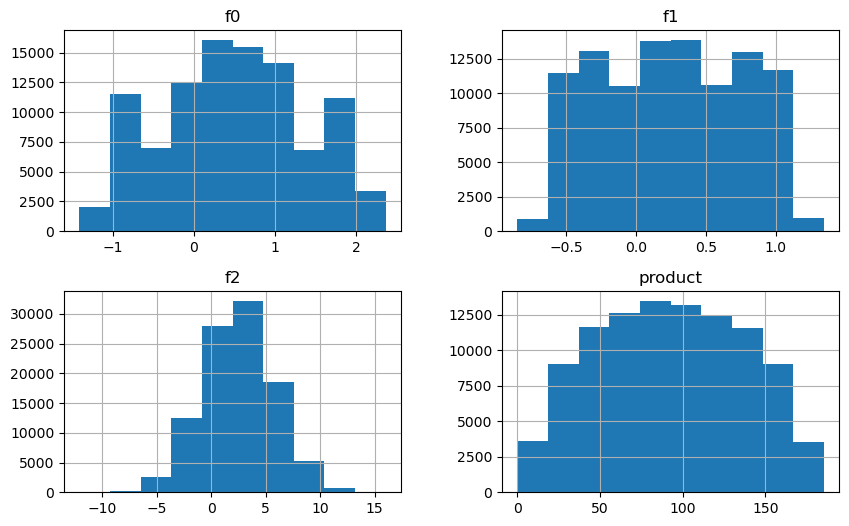

In [10]:
#построим гистограммы по регионам
data0.hist(figsize=(10,6))

array([[<Axes: title={'center': 'f0'}>, <Axes: title={'center': 'f1'}>],
       [<Axes: title={'center': 'f2'}>,
        <Axes: title={'center': 'product'}>]], dtype=object)

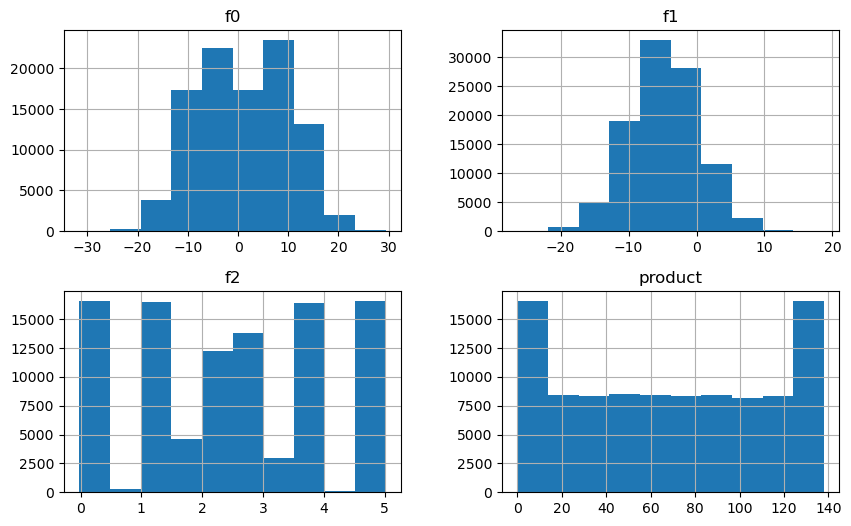

In [11]:
data1.hist(figsize=(10,6))

array([[<Axes: title={'center': 'f0'}>, <Axes: title={'center': 'f1'}>],
       [<Axes: title={'center': 'f2'}>,
        <Axes: title={'center': 'product'}>]], dtype=object)

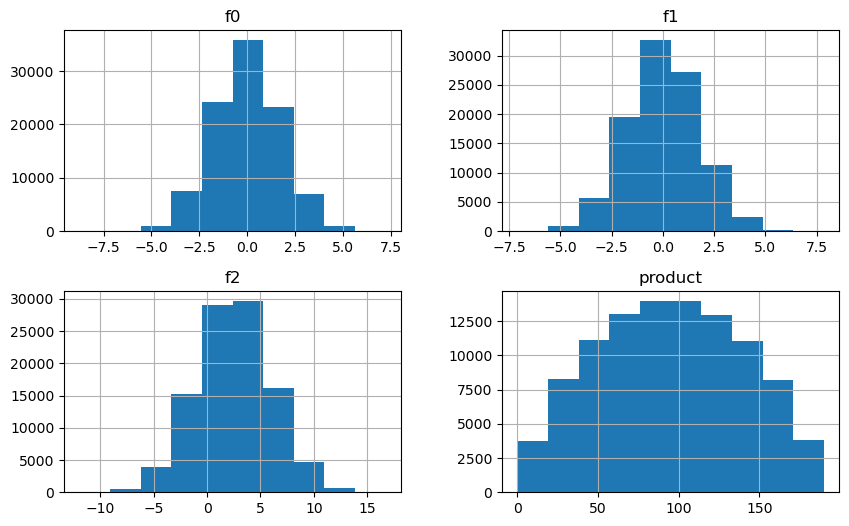

In [12]:
data2.hist(figsize=(10,6))

<Axes: >

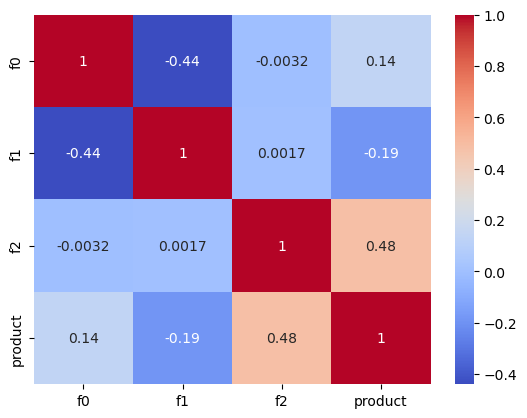

In [13]:
#построим график тепловую карту корреляции
sns.heatmap(data0.corr(), annot = True, cmap = 'coolwarm')

<Axes: >

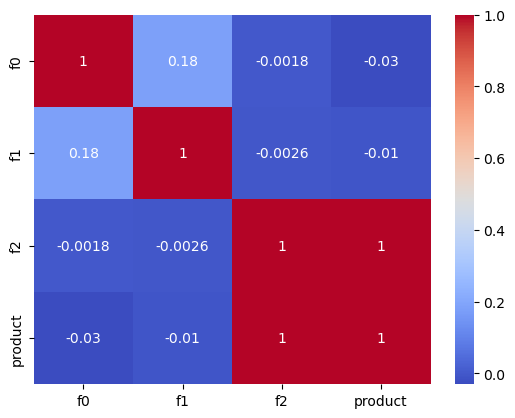

In [14]:
sns.heatmap(data1.corr(), annot = True, cmap = 'coolwarm')

<Axes: >

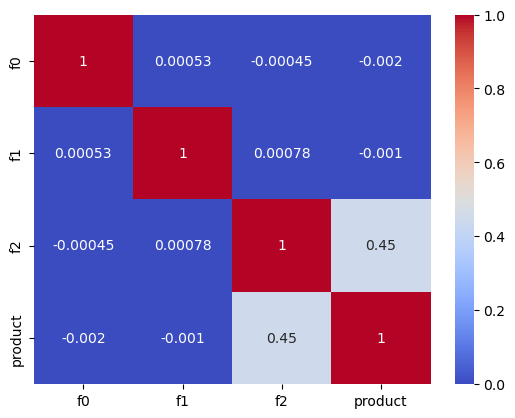

In [15]:
sns.heatmap(data2.corr(), annot = True, cmap = 'coolwarm')

## Обучение и проверка модели

In [16]:
#разобьем данные на выборки
target0 = data0['product']
features0 = data0.drop(['product', 'id'], axis=1)
features_train0, features_valid0, target_train0, target_valid0 = train_test_split(
    features0, target0, test_size=0.25, random_state=12345)
display(features_train0.shape)
display(features_valid0.shape)

(75000, 3)

(25000, 3)

In [17]:
target1 = data1['product']
features1 = data1.drop(['product', 'id'], axis=1)
features_train1, features_valid1, target_train1, target_valid1 = train_test_split(
    features1, target1, test_size=0.25, random_state=12345)
display(features_train1.shape)
display(features_valid1.shape)

(75000, 3)

(25000, 3)

In [18]:
target2 = data2['product']
features2 = data2.drop(['product', 'id'], axis=1)
features_train2, features_valid2, target_train2, target_valid2 = train_test_split(
    features2, target2, test_size=0.25, random_state=12345)
display(features_train2.shape)
display(features_valid2.shape)

(75000, 3)

(25000, 3)

In [19]:
#создадим список с числовыми столбцами
numeric = ['f0', 'f1', 'f2']

In [20]:
#нормируем числовые данные используя StandardScaler
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train0[numeric])
features_train0[numeric] = scaler.transform(features_train0[numeric])
features_valid0[numeric] = scaler.transform(features_valid0[numeric])

print(features_train0.shape)
print(features_valid0.shape)

(75000, 3)
(25000, 3)


In [21]:
scaler = StandardScaler()
scaler.fit(features_train1[numeric])
features_train1[numeric] = scaler.transform(features_train1[numeric])
features_valid1[numeric] = scaler.transform(features_valid1[numeric])

print(features_train1.shape)
print(features_valid1.shape)

(75000, 3)
(25000, 3)


In [22]:
scaler = StandardScaler()
scaler.fit(features_train2[numeric])
features_train2[numeric] = scaler.transform(features_train2[numeric])
features_valid2[numeric] = scaler.transform(features_valid2[numeric])

print(features_train2.shape)
print(features_valid2.shape)

(75000, 3)
(25000, 3)


In [23]:
#обучим модель линейной регрессии
model_lr0 = LinearRegression()
model_lr0.fit(features_train0, target_train0)
predicted_valid0 = model_lr0.predict(features_valid0)
rmse0 = mean_squared_error(target_valid0, predicted_valid0)**0.5
predicted_mean0 = predicted_valid0.mean()
print("Средний запас предсказанного сырья:", predicted_mean0)
print("RMSE модели линейной регрессии на валидационной выборке:", rmse0)

Средний запас предсказанного сырья: 92.59256778438035
RMSE модели линейной регрессии на валидационной выборке: 37.5794217150813


In [24]:
model_lr1 = LinearRegression()
model_lr1.fit(features_train1, target_train1)
predicted_valid1 = model_lr1.predict(features_valid1)
rmse1 = mean_squared_error(target_valid1, predicted_valid1)**0.5
predicted_mean1 = predicted_valid1.mean()
print("Средний запас предсказанного сырья:", predicted_mean1)
print("RMSE модели линейной регрессии на валидационной выборке:", rmse1)

Средний запас предсказанного сырья: 68.728546895446
RMSE модели линейной регрессии на валидационной выборке: 0.8930992867756168


In [25]:
model_lr2 = LinearRegression()
model_lr2.fit(features_train2, target_train2)
predicted_valid2 = model_lr2.predict(features_valid2)
rmse2 = mean_squared_error(target_valid2, predicted_valid2)**0.5
predicted_mean2 = predicted_valid2.mean()
print("Средний запас предсказанного сырья:", predicted_mean2)
print("RMSE модели линейной регрессии на валидационной выборке:", rmse2)

Средний запас предсказанного сырья: 94.96504596800489
RMSE модели линейной регрессии на валидационной выборке: 40.02970873393434


**Вывод:**

В регионе 0 получились значения:
- Средний запас предсказанного сырья: 92.59
- RMSE модели линейной регрессии на валидационной выборке: 37.58

В регионе 1 получились значения:
- Средний запас предсказанного сырья: 68.73
- RMSE модели линейной регрессии на валидационной выборке: 0.89

В регионе 2 получились значения:
- Средний запас предсказанного сырья: 94.97
- RMSE модели линейной регрессии на валидационной выборке: 40.03

Больше всего среднего запаса предсказанного сырья в регионе 2. Самое лучшее значение RMSE в регионе 1.

## Подготовка к расчёту прибыли

In [26]:
#рассчитаем достаточный объем сырья для безубыточной разработки новой скважины
print('Объем сырья для безубыточной разработки новой скважины:', BUDGET/PRICE/OIL_WELL)

Объем сырья для безубыточной разработки новой скважины: 111.11111111111111


In [27]:
#сравним полученный объем сырья со средним запасом в каждом регионе
print('Средний объем запасов скважины в 0-м регионе:', data0['product'].mean())
print('Средний объем запасов скважины в 1-м регионе:', data1['product'].mean())
print('Средний объем запасов скважины в 2-м регионе:', data2['product'].mean())

Средний объем запасов скважины в 0-м регионе: 92.50000000000001
Средний объем запасов скважины в 1-м регионе: 68.82500000000002
Средний объем запасов скважины в 2-м регионе: 95.00000000000004


**Вывод:**

 Объем сырья для безубыточной разработки новой скважины равен 111.11.
 
 Средний объем сырья в каждом регионе значительно меньше и равен:
 - Средний объем запасов скважины в 0-м регионе: 92.5
 - Средний объем запасов скважины в 1-м регионе: 68.83
 - Средний объем запасов скважины в 2-м регионе: 95.0

## Расчёт прибыли и рисков 

In [28]:
#напишем функцию расчета прибыли
def revenue(target, predicted, cost, count):
    probs_sorted = predicted.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return cost * selected.sum() - BUDGET

In [29]:
#применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли
#посчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков
state = np.random.RandomState(12345)  
values0 = []
df0 = pd.DataFrame({'target': target_valid0, 'predicted': predicted_valid0})

for i in range(1000):
    df0_sample = df0.sample(n=500, replace=True, random_state=state) 
    df0_sample = df0_sample.sort_values(by='predicted') 
    target_subsample0 = df0_sample['target'] 
    predicted_subsample0 = df0_sample['predicted'] 
    values0.append(revenue(target_subsample0, predicted_subsample0, PRICE, 200))
    
values0 = pd.Series(values0)
lower0 = values0.quantile(0.025)
upper0 = values0.quantile(0.975)
mean0 = values0.mean()
risk_of_loss0 = values0[values0<0].count() / 1000

print("Средняя выручка:", mean0)
print("95%-й Доверительный интервал:", (lower0, upper0))
print("Риск убытков:", risk_of_loss0 * 100, "%")

Средняя выручка: 425938526.91059244
95%-й Доверительный интервал: (-102090094.83793654, 947976353.3583689)
Риск убытков: 6.0 %


In [30]:
values1 = []
df1 = pd.DataFrame({'target': target_valid1, 'predicted': predicted_valid1})

for i in range(1000):
    df1_sample = df1.sample(n=500, replace=True, random_state=state) 
    df1_sample = df1_sample.sort_values(by='predicted') 
    target_subsample1 = df1_sample['target'] 
    predicted_subsample1 = df1_sample['predicted'] 
    values1.append(revenue(target_subsample1, predicted_subsample1, PRICE, 200))

values1 = pd.Series(values1)
lower1 = values1.quantile(0.025)
upper1 = values1.quantile(0.975)
mean1 = values1.mean()
risk_of_loss1 = values1[values1<0].count() / 1000

print("Средняя выручка:", mean1)
print("95%-й Доверительный интервал:", (lower1, upper1))
print("Риск убытков:", risk_of_loss1 * 100, "%")

Средняя выручка: 518259493.6973249
95%-й Доверительный интервал: (128123231.43308444, 953612982.0669085)
Риск убытков: 0.3 %


In [31]:
state = np.random.RandomState(12345)  
values2 = []
df2 = pd.DataFrame({'target': target_valid2, 'predicted': predicted_valid2})

for i in range(1000):
    df2_sample = df2.sample(n=500, replace=True, random_state=state) 
    df2_sample = df2_sample.sort_values(by='predicted') 
    target_subsample2 = df2_sample['target'] 
    predicted_subsample2 = df2_sample['predicted'] 
    values2.append(revenue(target_subsample2, predicted_subsample2, PRICE, 200))

values2 = pd.Series(values2)
lower2 = values2.quantile(0.025)
upper2 = values2.quantile(0.975)
mean2 = values2.mean()
risk_of_loss2 = values2[values2<0].count() / 1000

print("Средняя выручка:", mean2)
print("95%-й Доверительный интервал:", (lower2, upper2))
print("Риск убытков:", risk_of_loss2 *100, "%")

Средняя выручка: 435008362.7827556
95%-й Доверительный интервал: (-128880547.32978901, 969706954.1802661)
Риск убытков: 6.4 %


In [32]:
#сделаем отдельный датафрейм по регионам
pd.set_option('display.float_format', '{:.2f}'.format)
df = pd.DataFrame(data=[[mean0, str((lower0, upper0)), risk_of_loss0 * 100],
                       [mean1, str((lower1, upper1)), risk_of_loss1 * 100],
                       [mean2, str((lower2, upper2)), risk_of_loss2 * 100]],
                  columns=['Средняя прибыль', '95%-й Доверительный интервал', 'Риск убытков %'])
print(df)

   Средняя прибыль              95%-й Доверительный интервал  Риск убытков %
0     425938526.91  (-102090094.83793654, 947976353.3583689)            6.00
1     518259493.70   (128123231.43308444, 953612982.0669085)            0.30
2     435008362.78  (-128880547.32978901, 969706954.1802661)            6.40


**Вывод:**
 
Показатели для 0-региона:
 
- Средняя выручка: 425938526.91
- 95%-й Доверительный интервал: (-102090094.84, 947976353.36)
- Риск убытков: 6.0 %

Показатели для 1-региона:
 
- Средняя выручка: 518259493.70
- 95%-й Доверительный интервал: (128123231.43, 953612982.07)
- Риск убытков: 0.3 %

Показатели для 2-региона:

- Средняя выручка: 435008362.78
- 95%-й Доверительный интервал: (-128880547.33, 969706954.18)
- Риск убытков: 6.4 %

Средняя выручка большего всего в 1-регионе, лучшие значения 95% доверительного интервала у 1-региона и меньше всего риск убытков в 1-регионе

**Общий вывод:**

  Лучший регион для разработки скважин это 1-регион, он имеет самый низкий риск убытков `0.3%`, имеет самую большу среднюю выручку `518259493.70`, лучшие значения 95% доверительного интервала `128123231.43 - 953612982.07`